# Instalações e importações

In [1]:
!pip install --upgrade tensorflow tensorflow-hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 1.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.0
    Uninstalling tensorflow-2.17.0:
      Successfully uninstalled tensorflow-2.17.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [3]:
!gdown 1HjSh2EqVe2z5nE-hqX8B8X4FMKX8kOx0

Downloading...
From: https://drive.google.com/uc?id=1HjSh2EqVe2z5nE-hqX8B8X4FMKX8kOx0
To: /content/wine-reviews.csv
100% 52.9M/52.9M [00:00<00:00, 232MB/s]


# Preliminares

In [4]:
df = pd.read_csv('wine-reviews.csv', index_col=0)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


In [5]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


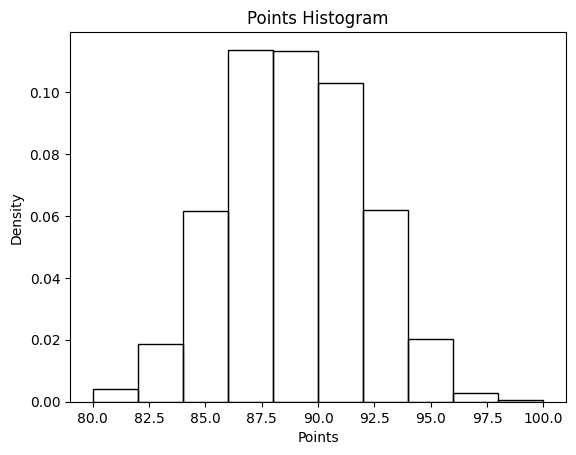

In [6]:
df['points'].hist(grid = False,
                  edgecolor='black',
                  facecolor='none',
                  density = True)

plt.title('Points Histogram')
plt.xlabel('Points')
plt.ylabel('Density')

plt.show()

In [7]:
df['label'] = (df['points'] >= 90).astype(int)

df = df[['description','label']]

In [8]:
train, val , test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [9]:
len(train), len(val), len(test)

(103976, 12997, 12998)

In [10]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
    df = dataframe.copy()
    labels = df.pop('label')
    df = df["description"]
    ds = tf.data.Dataset.from_tensor_slices((df, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [11]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

# Embedding e Modelo

In [16]:
tf.keras.Layer

keras.src.layers.layer.Layer

In [22]:
class CustomEmbeddingLayer(tf.keras.Layer):
    def __init__(self, url, trainable=True, **kwargs):
        super(CustomEmbeddingLayer, self).__init__(**kwargs)
        # Inicializa o hub.KerasLayer com o URL fornecido
        self.embedding_layer = hub.KerasLayer(url,
                                              input_shape=[],
                                              dtype=tf.string,
                                              trainable=trainable)

    def call(self, inputs):
        # Passa as entradas pela camada de embeddings
        return self.embedding_layer(inputs)

In [26]:
input_text = tf.keras.Input(shape=(), dtype=tf.string)

# Usa a camada customizada no modelo funcional
embedding_output = CustomEmbeddingLayer("https://tfhub.dev/google/nnlm-en-dim50/2")(input_text)
dense_1 = tf.keras.layers.Dense(16, activation='relu')(embedding_output)
dense_2 = tf.keras.layers.Dense(16, activation='relu')(dense_1)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense_2)


# Cria o modelo
model = tf.keras.Model(inputs=input_text, outputs=output)

# Imprime o resumo do modelo
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None)                      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_embedding_layer_2             │ (None, 50)                  │               0 │
│ (CustomEmbeddingLayer)               │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,105 (4.32 KB)

 Trainable params: 1,105 (4.32 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [28]:
model.evaluate(train_data)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3840 - loss: 0.7064


[0.7063840627670288, 0.3849157392978668]

In [30]:
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=30)

Epoch 1/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7103 - loss: 0.5625 - val_accuracy: 0.7084 - val_loss: 0.5622
Epoch 2/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7106 - loss: 0.5617 - val_accuracy: 0.7077 - val_loss: 0.5609
Epoch 3/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7128 - loss: 0.5605 - val_accuracy: 0.7088 - val_loss: 0.5602
Epoch 4/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7103 - loss: 0.5617 - val_accuracy: 0.7093 - val_loss: 0.5601
Epoch 5/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7142 - loss: 0.5587 - val_accuracy: 0.7117 - val_loss: 0.5603
Epoch 6/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7113 - loss: 0.5596 - val_accuracy: 0.7080 - val_loss: 0.5603
Epoch 7/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7160 - loss: 0.5576 - val_accuracy: 0.7105 - val_loss: 0.5589
Epoch 8/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7134 - loss: 0.5575 - val_accu

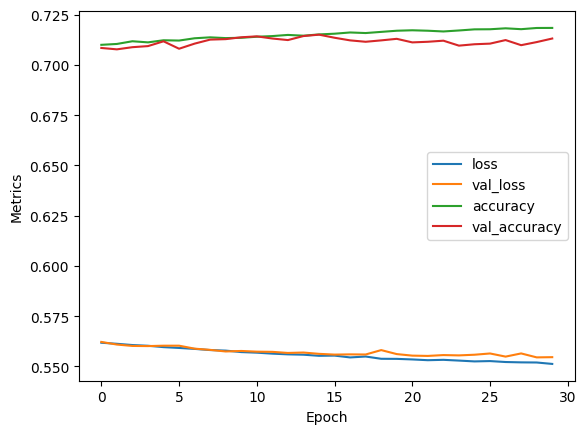

In [32]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')

plt.xlabel('Epoch')
plt.ylabel('Metrics')

plt.legend()
plt.show()

In [33]:
model.evaluate(test_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7143 - loss: 0.5609


[0.5564776062965393, 0.7138790488243103]

# LSTM

In [34]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [35]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [38]:
import tensorflow as tf

# Definindo o modelo sequencial
model = tf.keras.Sequential([

    # Encoder pré-definido que processa tokens de texto em índices de inteiros
    encoder,

    # Camada de embedding para transformar cada token em um vetor de tamanho fixo
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),  # Define o tamanho do vocabulário baseado no encoder
        output_dim=32,  # Define a dimensionalidade dos embeddings (cada token vira um vetor de 32 dimensões)
        mask_zero=True  # Ignora tokens com valor zero para lidar com sequências de tamanhos variáveis
    ),

    # Camada LSTM (Long Short-Term Memory) para capturar dependências temporais/sequenciais nos dados
    tf.keras.layers.LSTM(32),  # Define 32 unidades na LSTM para modelar a sequência de forma eficiente

    # Camada densa totalmente conectada com 32 unidades e ativação ReLU
    tf.keras.layers.Dense(32, activation='relu'),  # A ativação ReLU introduz não-linearidade no modelo

    # Camada de Dropout para prevenir overfitting desativando 40% dos neurônios aleatoriamente durante o treino
    tf.keras.layers.Dropout(0.4),  # Dropout rate de 40%, mantendo o modelo mais generalizado

    # Camada de saída densa com uma unidade e ativação sigmoide para produzir a probabilidade de uma classe binária
    tf.keras.layers.Dense(1, activation='sigmoid')  # Sigmoide para gerar uma saída entre 0 e 1, ideal para classificação binária
])


In [39]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ ?                           │     0 (unbuilt) │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [41]:
model.evaluate(valid_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - accuracy: 0.5507 - loss: 0.6928


[0.6927458643913269, 0.5569747090339661]

In [42]:
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=10)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 55s 498ms/step - accuracy: 0.6509 - loss: 0.6259 - val_accuracy: 0.8195 - val_loss: 0.3919
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 82s 501ms/step - accuracy: 0.8288 - loss: 0.3867 - val_accuracy: 0.8373 - val_loss: 0.3575
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 82s 499ms/step - accuracy: 0.8440 - loss: 0.3528 - val_accuracy: 0.8373 - val_loss: 0.3507
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 80s 485ms/step - accuracy: 0.8486 - loss: 0.3440 - val_accuracy: 0.8398 - val_loss: 0.3485
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 48s 467ms/step - accuracy: 0.8500 - loss: 0.3396 - val_accuracy: 0.8390 - val_loss: 0.3498
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 48s 471ms/step - accuracy: 0.8511 - loss: 0.3347 - val_accuracy: 0.8387 - val_loss: 0.3482
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 83s 484ms/step - accuracy: 0.8533 - loss: 0.3310 - val_accuracy: 0.8398 - val_loss: 0.3489
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 48s 470ms/step - accuracy: 0.8522 - loss: 0